# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

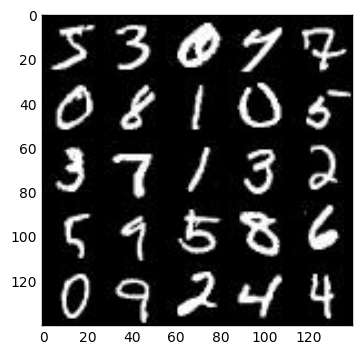

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

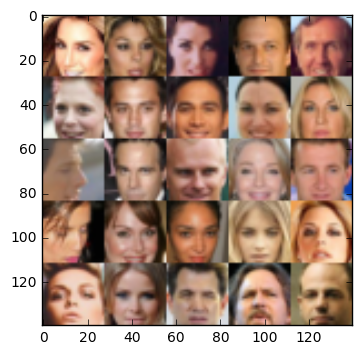

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels),
                                 name='input_real') 
    
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        # Input layer is 28x28x(1 for MNIST, 3 for face)
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128

        # Flatten it
        flat = tf.reshape(x2, (-1, 7*7*256))
        dropout = tf.layers.dropout(flat, rate=0.5)
        logits = tf.layers.dense(dropout, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [59]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    if is_train==True:
        reuse=False
    else:
        reuse=True
        
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*64, 
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 64))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now

        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x2 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x2 = tf.layers.conv2d_transpose(x2, 32, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [60]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.random_uniform(tf.shape(d_model_real),0.9,1.1)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.random_uniform(tf.shape(d_model_fake),0,0.1)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.random_uniform(tf.shape(d_model_fake),0.9,1.1)))

    d_loss = d_loss_real + d_loss_fake    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [61]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [62]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [63]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
   
    # TODO: Build Model
    tf.reset_default_graph()
    # create input placeholders
    if data_image_mode=="RGB":
        out_channel_dim=3
    else:
        out_channel_dim=1
        
    input_real, input_z, lr_place=model_inputs(data_shape[2], data_shape[1], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    # Training
    saver = tf.train.Saver()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    print_every=10
    show_every=150
    steps = 0        
    with sess.as_default():
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # rescale the image ouput from +-0.5 to +-1.0
                batch_images=batch_images*2
                
                # Sample random noise for G
                steps+=1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    n_images=25
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
            #saver.save(sess, './checkpoints/generator.ckpt')
            
    
    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
    sess.close()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2837... Generator Loss: 2.1056
Epoch 1/2... Discriminator Loss: 1.9575... Generator Loss: 0.1965
Epoch 1/2... Discriminator Loss: 3.7658... Generator Loss: 0.0389
Epoch 1/2... Discriminator Loss: 1.6416... Generator Loss: 0.2757
Epoch 1/2... Discriminator Loss: 0.4381... Generator Loss: 1.9216
Epoch 1/2... Discriminator Loss: 0.4637... Generator Loss: 1.4614
Epoch 1/2... Discriminator Loss: 0.3197... Generator Loss: 3.2561
Epoch 1/2... Discriminator Loss: 0.5831... Generator Loss: 1.0926
Epoch 1/2... Discriminator Loss: 0.5584... Generator Loss: 2.1733
Epoch 1/2... Discriminator Loss: 0.4469... Generator Loss: 2.2128
Epoch 1/2... Discriminator Loss: 0.4449... Generator Loss: 2.3205
Epoch 1/2... Discriminator Loss: 0.5530... Generator Loss: 2.8320
Epoch 1/2... Discriminator Loss: 0.7558... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 0.4408... Generator Loss: 1.8996
Epoch 1/2... Discriminator Loss: 0.4387... Generator Loss: 1.8458


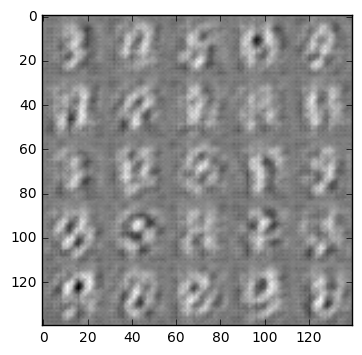

Epoch 1/2... Discriminator Loss: 0.6053... Generator Loss: 2.3286
Epoch 1/2... Discriminator Loss: 0.6624... Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 1.2106... Generator Loss: 5.1526
Epoch 1/2... Discriminator Loss: 0.7744... Generator Loss: 2.4222
Epoch 1/2... Discriminator Loss: 0.6231... Generator Loss: 1.8756
Epoch 1/2... Discriminator Loss: 0.5675... Generator Loss: 2.1644
Epoch 1/2... Discriminator Loss: 1.0068... Generator Loss: 2.4522
Epoch 1/2... Discriminator Loss: 1.0744... Generator Loss: 0.4709
Epoch 1/2... Discriminator Loss: 0.8403... Generator Loss: 2.2675
Epoch 1/2... Discriminator Loss: 0.8299... Generator Loss: 0.7479
Epoch 1/2... Discriminator Loss: 0.5912... Generator Loss: 1.4135
Epoch 1/2... Discriminator Loss: 0.8103... Generator Loss: 2.7671
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.3798
Epoch 1/2... Discriminator Loss: 1.1593... Generator Loss: 0.5133
Epoch 1/2... Discriminator Loss: 0.7999... Generator Loss: 0.9413


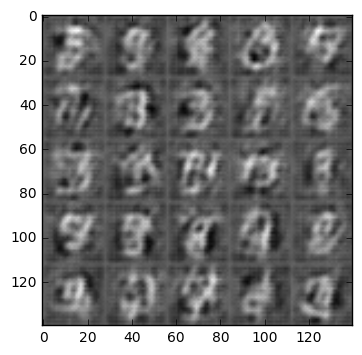

Epoch 1/2... Discriminator Loss: 0.9101... Generator Loss: 2.9189
Epoch 1/2... Discriminator Loss: 1.2027... Generator Loss: 0.4481
Epoch 1/2... Discriminator Loss: 0.6713... Generator Loss: 1.5995
Epoch 1/2... Discriminator Loss: 0.8677... Generator Loss: 0.9236
Epoch 1/2... Discriminator Loss: 0.6153... Generator Loss: 1.9364
Epoch 1/2... Discriminator Loss: 0.5387... Generator Loss: 1.4875
Epoch 1/2... Discriminator Loss: 0.8428... Generator Loss: 1.3165
Epoch 1/2... Discriminator Loss: 0.6022... Generator Loss: 1.6439
Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 1.6317
Epoch 1/2... Discriminator Loss: 1.0991... Generator Loss: 0.4979
Epoch 1/2... Discriminator Loss: 0.7572... Generator Loss: 0.9466
Epoch 1/2... Discriminator Loss: 0.8381... Generator Loss: 1.4563
Epoch 1/2... Discriminator Loss: 0.7140... Generator Loss: 1.7720
Epoch 1/2... Discriminator Loss: 0.7362... Generator Loss: 1.2209
Epoch 1/2... Discriminator Loss: 0.7655... Generator Loss: 2.1485


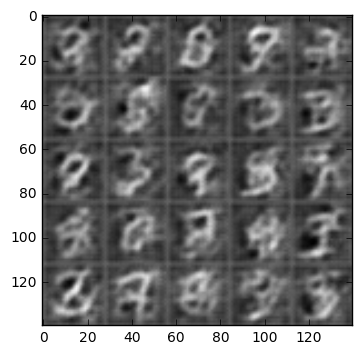

Epoch 1/2... Discriminator Loss: 1.5292... Generator Loss: 0.3080
Epoch 1/2... Discriminator Loss: 0.7592... Generator Loss: 1.4310
Epoch 1/2... Discriminator Loss: 0.8723... Generator Loss: 0.7648
Epoch 1/2... Discriminator Loss: 0.9735... Generator Loss: 2.0278
Epoch 1/2... Discriminator Loss: 0.6924... Generator Loss: 1.3705
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 1.3862
Epoch 1/2... Discriminator Loss: 1.0518... Generator Loss: 0.6523
Epoch 1/2... Discriminator Loss: 0.7938... Generator Loss: 1.5271
Epoch 1/2... Discriminator Loss: 0.8493... Generator Loss: 1.0057
Epoch 1/2... Discriminator Loss: 1.1466... Generator Loss: 0.4929
Epoch 1/2... Discriminator Loss: 1.1105... Generator Loss: 0.5129
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 0.5250
Epoch 1/2... Discriminator Loss: 0.8642... Generator Loss: 0.8692
Epoch 1/2... Discriminator Loss: 0.9507... Generator Loss: 2.6383
Epoch 1/2... Discriminator Loss: 0.7299... Generator Loss: 1.9497


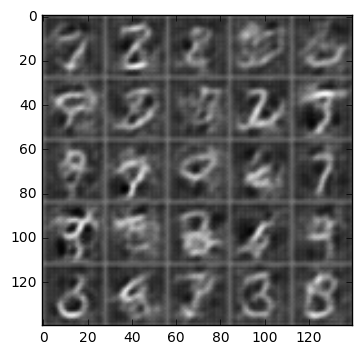

Epoch 1/2... Discriminator Loss: 0.8028... Generator Loss: 1.2205
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 2.6014
Epoch 1/2... Discriminator Loss: 0.9255... Generator Loss: 0.9254
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 0.6635
Epoch 1/2... Discriminator Loss: 1.1569... Generator Loss: 0.8536
Epoch 1/2... Discriminator Loss: 1.7383... Generator Loss: 3.1579
Epoch 1/2... Discriminator Loss: 1.6617... Generator Loss: 0.3116
Epoch 1/2... Discriminator Loss: 1.0103... Generator Loss: 1.2747
Epoch 1/2... Discriminator Loss: 0.8155... Generator Loss: 1.1631
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 0.5469
Epoch 1/2... Discriminator Loss: 1.6932... Generator Loss: 0.3564
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.3835
Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 0.9264
Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 1.8004
Epoch 1/2... Discriminator Loss: 1.0289... Generator Loss: 1.6998


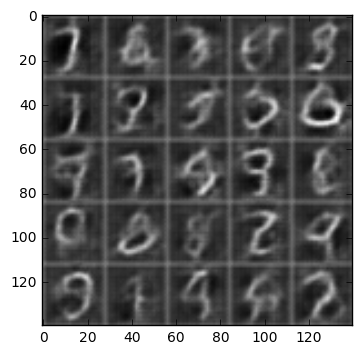

Epoch 1/2... Discriminator Loss: 0.7819... Generator Loss: 1.1756
Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 1.2550
Epoch 1/2... Discriminator Loss: 0.8789... Generator Loss: 0.8831
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.8348
Epoch 1/2... Discriminator Loss: 0.9449... Generator Loss: 1.2962
Epoch 1/2... Discriminator Loss: 0.9175... Generator Loss: 0.9238
Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 0.5574
Epoch 1/2... Discriminator Loss: 0.8636... Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 0.8718
Epoch 1/2... Discriminator Loss: 2.0287... Generator Loss: 0.2353
Epoch 1/2... Discriminator Loss: 1.5822... Generator Loss: 0.8995
Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 1.0400
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 1.3516
Epoch 1/2... Discriminator Loss: 1.0766... Generator Loss: 0.7717


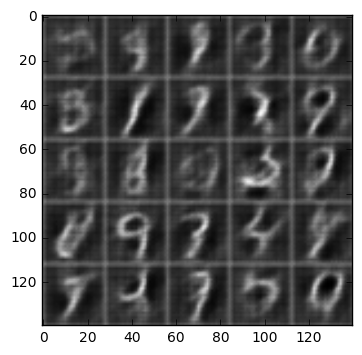

Epoch 1/2... Discriminator Loss: 1.2661... Generator Loss: 0.4735
Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 0.9543
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 0.6971
Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 0.9224
Epoch 2/2... Discriminator Loss: 1.0135... Generator Loss: 0.6549
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 0.9993
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 0.7194
Epoch 2/2... Discriminator Loss: 1.0203... Generator Loss: 0.6963
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 1.6724
Epoch 2/2... Discriminator Loss: 1.4506... Generator Loss: 0.4014
Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 0.9604
Epoch 2/2... Discriminator Loss: 1.3814... Generator Loss: 1.8470
Epoch 2/2... Discriminator Loss: 0.9963... Generator Loss: 0.8379
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.3912
Epoch 2/2... Discriminator Loss: 0.8107... Generator Loss: 1.2328


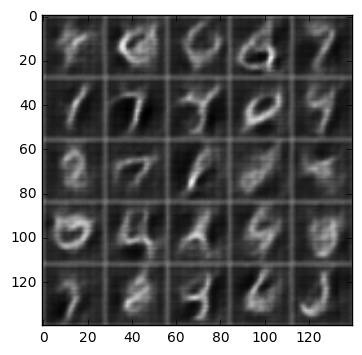

Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 1.1607
Epoch 2/2... Discriminator Loss: 0.7177... Generator Loss: 1.4014
Epoch 2/2... Discriminator Loss: 1.1770... Generator Loss: 0.5987
Epoch 2/2... Discriminator Loss: 0.9650... Generator Loss: 1.3253
Epoch 2/2... Discriminator Loss: 0.7869... Generator Loss: 1.0014
Epoch 2/2... Discriminator Loss: 0.8258... Generator Loss: 1.9146
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 0.7759
Epoch 2/2... Discriminator Loss: 0.7790... Generator Loss: 1.0683
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 0.9848
Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 0.5020
Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 1.7177
Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 0.6797
Epoch 2/2... Discriminator Loss: 0.8677... Generator Loss: 1.4057
Epoch 2/2... Discriminator Loss: 1.0146... Generator Loss: 0.6632
Epoch 2/2... Discriminator Loss: 0.9506... Generator Loss: 0.8082


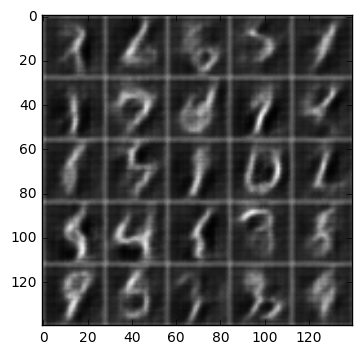

Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 1.0894... Generator Loss: 0.6317
Epoch 2/2... Discriminator Loss: 0.9696... Generator Loss: 1.3280
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 1.0843
Epoch 2/2... Discriminator Loss: 1.6227... Generator Loss: 2.9683
Epoch 2/2... Discriminator Loss: 0.9430... Generator Loss: 0.9096
Epoch 2/2... Discriminator Loss: 0.9609... Generator Loss: 0.8748
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.4382
Epoch 2/2... Discriminator Loss: 0.9810... Generator Loss: 1.5355
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 1.7036
Epoch 2/2... Discriminator Loss: 0.8726... Generator Loss: 1.2241
Epoch 2/2... Discriminator Loss: 1.1893... Generator Loss: 1.5317
Epoch 2/2... Discriminator Loss: 0.8548... Generator Loss: 1.1672
Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 3.1996... Generator Loss: 0.0666


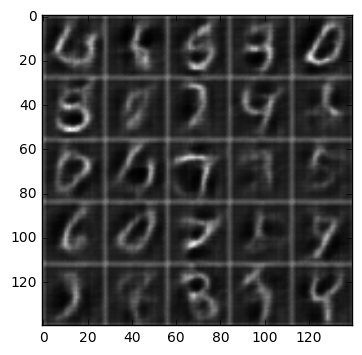

Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 1.0552
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.0952
Epoch 2/2... Discriminator Loss: 0.9345... Generator Loss: 0.9271
Epoch 2/2... Discriminator Loss: 0.8658... Generator Loss: 1.0331
Epoch 2/2... Discriminator Loss: 2.5691... Generator Loss: 0.1024
Epoch 2/2... Discriminator Loss: 1.2190... Generator Loss: 0.5671
Epoch 2/2... Discriminator Loss: 0.9556... Generator Loss: 1.2241
Epoch 2/2... Discriminator Loss: 0.9517... Generator Loss: 0.9355
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 1.2233
Epoch 2/2... Discriminator Loss: 0.9646... Generator Loss: 0.9456
Epoch 2/2... Discriminator Loss: 1.0248... Generator Loss: 0.6707
Epoch 2/2... Discriminator Loss: 1.5250... Generator Loss: 3.1376
Epoch 2/2... Discriminator Loss: 0.9064... Generator Loss: 1.1055
Epoch 2/2... Discriminator Loss: 0.7784... Generator Loss: 1.0593
Epoch 2/2... Discriminator Loss: 1.1113... Generator Loss: 1.7749


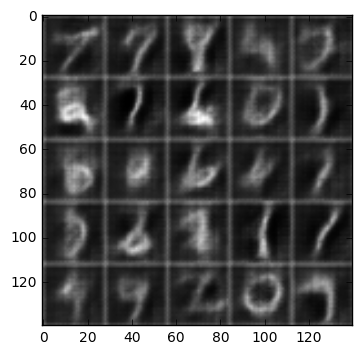

Epoch 2/2... Discriminator Loss: 0.9089... Generator Loss: 0.9670
Epoch 2/2... Discriminator Loss: 0.8457... Generator Loss: 1.1054
Epoch 2/2... Discriminator Loss: 0.9794... Generator Loss: 1.4606
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 1.4235
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 0.9489
Epoch 2/2... Discriminator Loss: 0.8281... Generator Loss: 1.1005
Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 0.6180
Epoch 2/2... Discriminator Loss: 1.2767... Generator Loss: 1.4759
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 0.7875
Epoch 2/2... Discriminator Loss: 0.9714... Generator Loss: 1.5334
Epoch 2/2... Discriminator Loss: 1.0121... Generator Loss: 1.2770
Epoch 2/2... Discriminator Loss: 0.9475... Generator Loss: 1.1288
Epoch 2/2... Discriminator Loss: 0.9300... Generator Loss: 0.9882
Epoch 2/2... Discriminator Loss: 0.9248... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 1.0158... Generator Loss: 2.0269


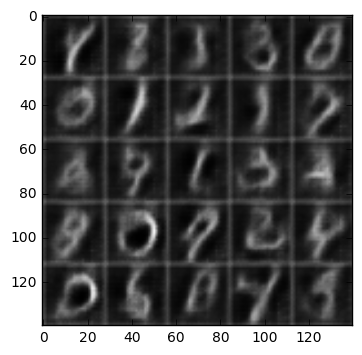

Epoch 2/2... Discriminator Loss: 1.2607... Generator Loss: 1.7927
Epoch 2/2... Discriminator Loss: 0.7485... Generator Loss: 1.1450
Epoch 2/2... Discriminator Loss: 1.0209... Generator Loss: 0.7311
Epoch 2/2... Discriminator Loss: 1.0700... Generator Loss: 0.6985
Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 0.6749
Epoch 2/2... Discriminator Loss: 2.0828... Generator Loss: 0.2062
Epoch 2/2... Discriminator Loss: 1.1193... Generator Loss: 0.6241
Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 0.9796... Generator Loss: 1.0607
Epoch 2/2... Discriminator Loss: 0.7867... Generator Loss: 1.2128
Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 2.0047
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 0.9401
Epoch 2/2... Discriminator Loss: 0.9491... Generator Loss: 0.8390
Epoch 2/2... Discriminator Loss: 0.7922... Generator Loss: 0.9500
Epoch 2/2... Discriminator Loss: 1.0528... Generator Loss: 0.6302


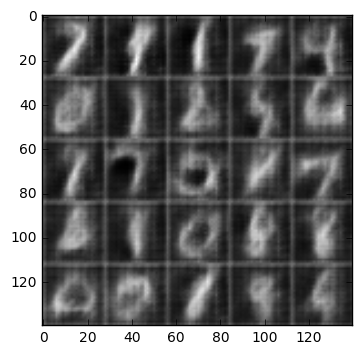

Epoch 2/2... Discriminator Loss: 0.9748... Generator Loss: 1.0168
Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 0.3946
Epoch 2/2... Discriminator Loss: 1.1024... Generator Loss: 0.6828
Epoch 2/2... Discriminator Loss: 1.1885... Generator Loss: 0.6046
Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 0.6958... Generator Loss: 1.2831
Epoch 2/2... Discriminator Loss: 0.7822... Generator Loss: 1.1967


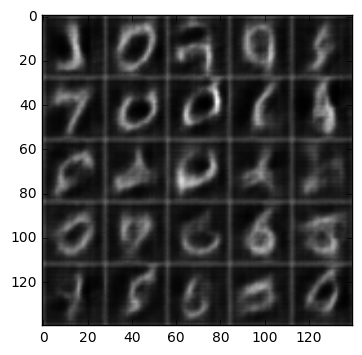

IndexError: list index out of range

In [65]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 1.8707
Epoch 1/1... Discriminator Loss: 0.2114... Generator Loss: 2.0060
Epoch 1/1... Discriminator Loss: 0.3226... Generator Loss: 2.0743
Epoch 1/1... Discriminator Loss: 0.2404... Generator Loss: 2.2624
Epoch 1/1... Discriminator Loss: 0.2013... Generator Loss: 2.6229
Epoch 1/1... Discriminator Loss: 0.2585... Generator Loss: 2.4955
Epoch 1/1... Discriminator Loss: 0.1598... Generator Loss: 2.5903
Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 2.2921
Epoch 1/1... Discriminator Loss: 0.2878... Generator Loss: 2.6205
Epoch 1/1... Discriminator Loss: 0.2168... Generator Loss: 2.5565
Epoch 1/1... Discriminator Loss: 0.1827... Generator Loss: 1.8906
Epoch 1/1... Discriminator Loss: 0.2235... Generator Loss: 2.1317
Epoch 1/1... Discriminator Loss: 0.2335... Generator Loss: 2.6023
Epoch 1/1... Discriminator Loss: 0.2541... Generator Loss: 4.9112
Epoch 1/1... Discriminator Loss: 0.2385... Generator Loss: 3.2926


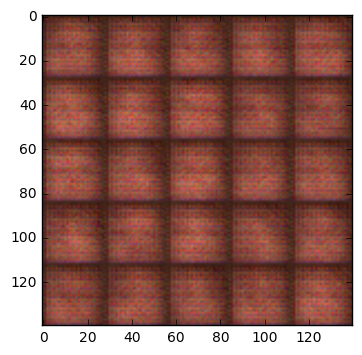

Epoch 1/1... Discriminator Loss: 0.1139... Generator Loss: 2.8095
Epoch 1/1... Discriminator Loss: 0.3823... Generator Loss: 1.9602
Epoch 1/1... Discriminator Loss: 0.1272... Generator Loss: 2.8278
Epoch 1/1... Discriminator Loss: 0.2866... Generator Loss: 2.6675
Epoch 1/1... Discriminator Loss: 0.2846... Generator Loss: 2.7895
Epoch 1/1... Discriminator Loss: 0.3577... Generator Loss: 3.1968
Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 3.8990
Epoch 1/1... Discriminator Loss: 0.4033... Generator Loss: 1.6238
Epoch 1/1... Discriminator Loss: 0.2257... Generator Loss: 2.6448
Epoch 1/1... Discriminator Loss: 0.1856... Generator Loss: 2.6507
Epoch 1/1... Discriminator Loss: 0.2394... Generator Loss: 2.0544
Epoch 1/1... Discriminator Loss: 0.2290... Generator Loss: 2.2167
Epoch 1/1... Discriminator Loss: 0.2807... Generator Loss: 2.0497
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 5.5992
Epoch 1/1... Discriminator Loss: 0.2614... Generator Loss: 2.4883


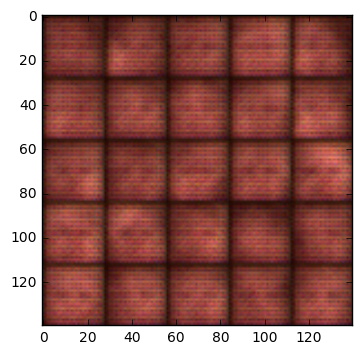

Epoch 1/1... Discriminator Loss: 0.2212... Generator Loss: 2.6881
Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 5.4212
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 2.1588
Epoch 1/1... Discriminator Loss: 0.2567... Generator Loss: 1.9116
Epoch 1/1... Discriminator Loss: 0.2381... Generator Loss: 2.3328
Epoch 1/1... Discriminator Loss: 0.2359... Generator Loss: 2.1749
Epoch 1/1... Discriminator Loss: 0.3362... Generator Loss: 2.0408
Epoch 1/1... Discriminator Loss: 0.3571... Generator Loss: 1.8032
Epoch 1/1... Discriminator Loss: 0.5210... Generator Loss: 1.3597
Epoch 1/1... Discriminator Loss: 0.1925... Generator Loss: 2.3585
Epoch 1/1... Discriminator Loss: 0.2456... Generator Loss: 2.0050
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 2.6457
Epoch 1/1... Discriminator Loss: 0.4436... Generator Loss: 1.8199
Epoch 1/1... Discriminator Loss: 0.3058... Generator Loss: 3.0133
Epoch 1/1... Discriminator Loss: 0.3278... Generator Loss: 2.4196


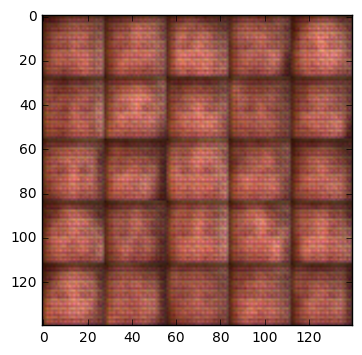

Epoch 1/1... Discriminator Loss: 0.2846... Generator Loss: 2.9216
Epoch 1/1... Discriminator Loss: 0.2908... Generator Loss: 2.1247
Epoch 1/1... Discriminator Loss: 0.3000... Generator Loss: 2.0478
Epoch 1/1... Discriminator Loss: 0.1559... Generator Loss: 2.7857
Epoch 1/1... Discriminator Loss: 0.3332... Generator Loss: 2.8539
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 1.7330
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 1.7310
Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 1.8840
Epoch 1/1... Discriminator Loss: 0.3153... Generator Loss: 2.3500
Epoch 1/1... Discriminator Loss: 0.4216... Generator Loss: 1.8730
Epoch 1/1... Discriminator Loss: 0.3352... Generator Loss: 2.2342
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 1.1340
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 1.7283
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 1.3533
Epoch 1/1... Discriminator Loss: 0.2925... Generator Loss: 2.0224


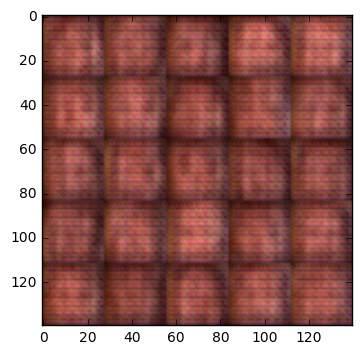

Epoch 1/1... Discriminator Loss: 0.2692... Generator Loss: 2.5736
Epoch 1/1... Discriminator Loss: 0.3426... Generator Loss: 3.1119
Epoch 1/1... Discriminator Loss: 0.2443... Generator Loss: 2.4507
Epoch 1/1... Discriminator Loss: 0.4676... Generator Loss: 1.4773
Epoch 1/1... Discriminator Loss: 0.2964... Generator Loss: 2.0613
Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 2.3247
Epoch 1/1... Discriminator Loss: 0.2394... Generator Loss: 2.4313
Epoch 1/1... Discriminator Loss: 0.4346... Generator Loss: 1.3732
Epoch 1/1... Discriminator Loss: 0.3088... Generator Loss: 2.4738
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 1.8574
Epoch 1/1... Discriminator Loss: 0.3097... Generator Loss: 2.9060
Epoch 1/1... Discriminator Loss: 0.2402... Generator Loss: 3.0961
Epoch 1/1... Discriminator Loss: 0.5581... Generator Loss: 3.7306
Epoch 1/1... Discriminator Loss: 0.3184... Generator Loss: 1.7183
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 1.6082


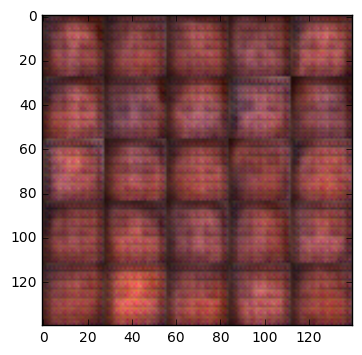

Epoch 1/1... Discriminator Loss: 0.3503... Generator Loss: 1.6373
Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 1.7737
Epoch 1/1... Discriminator Loss: 0.3560... Generator Loss: 2.4223
Epoch 1/1... Discriminator Loss: 0.3070... Generator Loss: 2.0727
Epoch 1/1... Discriminator Loss: 0.3605... Generator Loss: 3.0107
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 3.5678
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 2.1722
Epoch 1/1... Discriminator Loss: 0.2805... Generator Loss: 2.6548
Epoch 1/1... Discriminator Loss: 0.2854... Generator Loss: 2.4473
Epoch 1/1... Discriminator Loss: 0.3222... Generator Loss: 1.9868
Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 2.6480
Epoch 1/1... Discriminator Loss: 0.3094... Generator Loss: 1.9807
Epoch 1/1... Discriminator Loss: 0.6598... Generator Loss: 3.6050
Epoch 1/1... Discriminator Loss: 0.3694... Generator Loss: 2.4005
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 1.6714


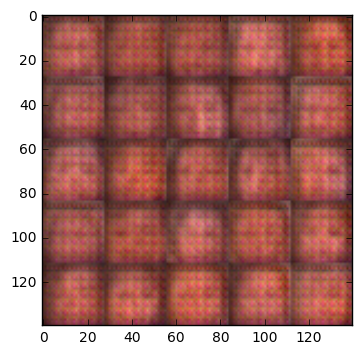

Epoch 1/1... Discriminator Loss: 0.3106... Generator Loss: 1.9787
Epoch 1/1... Discriminator Loss: 0.4939... Generator Loss: 1.3503
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 2.3537
Epoch 1/1... Discriminator Loss: 0.3299... Generator Loss: 1.6444
Epoch 1/1... Discriminator Loss: 0.2506... Generator Loss: 2.2473
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 0.3173... Generator Loss: 1.5433
Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 1.6854
Epoch 1/1... Discriminator Loss: 0.4251... Generator Loss: 1.5634
Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 1.8608
Epoch 1/1... Discriminator Loss: 0.3353... Generator Loss: 2.2457
Epoch 1/1... Discriminator Loss: 0.3632... Generator Loss: 1.7896
Epoch 1/1... Discriminator Loss: 0.3389... Generator Loss: 2.8915
Epoch 1/1... Discriminator Loss: 0.2548... Generator Loss: 2.2896
Epoch 1/1... Discriminator Loss: 0.4454... Generator Loss: 1.9739


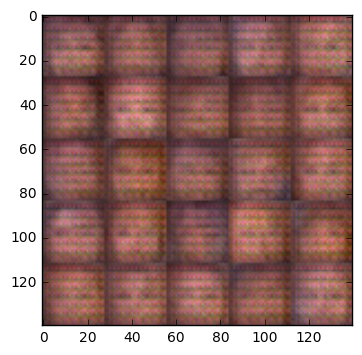

Epoch 1/1... Discriminator Loss: 0.3540... Generator Loss: 2.2332
Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 2.1630
Epoch 1/1... Discriminator Loss: 0.3730... Generator Loss: 2.0005
Epoch 1/1... Discriminator Loss: 0.3690... Generator Loss: 2.0022
Epoch 1/1... Discriminator Loss: 0.3969... Generator Loss: 3.0540
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 1.9693
Epoch 1/1... Discriminator Loss: 0.2107... Generator Loss: 2.3550
Epoch 1/1... Discriminator Loss: 0.3705... Generator Loss: 1.7123
Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 1.6781
Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 1.8678
Epoch 1/1... Discriminator Loss: 0.3736... Generator Loss: 1.8928
Epoch 1/1... Discriminator Loss: 0.2887... Generator Loss: 2.2986
Epoch 1/1... Discriminator Loss: 0.2977... Generator Loss: 2.0813
Epoch 1/1... Discriminator Loss: 0.3614... Generator Loss: 1.9121
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 2.9225


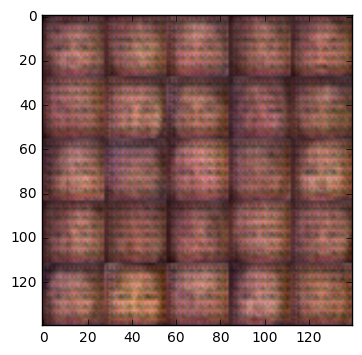

Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 5.1902
Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 1.9041
Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 1.6367
Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 1.5628
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 1.8826
Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 1.9432
Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 2.8731
Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 2.0776
Epoch 1/1... Discriminator Loss: 0.3583... Generator Loss: 2.3318
Epoch 1/1... Discriminator Loss: 0.3111... Generator Loss: 2.2815
Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 1.4601
Epoch 1/1... Discriminator Loss: 0.3498... Generator Loss: 1.8463
Epoch 1/1... Discriminator Loss: 0.3116... Generator Loss: 2.3092
Epoch 1/1... Discriminator Loss: 0.5425... Generator Loss: 1.6815
Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 2.0977


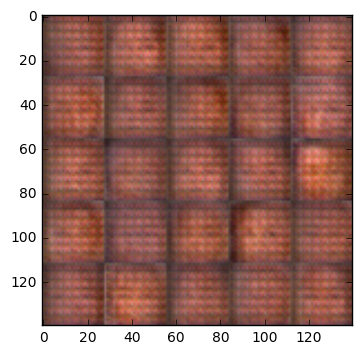

Epoch 1/1... Discriminator Loss: 0.4285... Generator Loss: 2.5583
Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 2.2868
Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 1.6087
Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 1.7637
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 2.2619
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 0.5775... Generator Loss: 1.4505
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 1.5207
Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 1.5835
Epoch 1/1... Discriminator Loss: 0.5134... Generator Loss: 1.4466
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 2.5481
Epoch 1/1... Discriminator Loss: 0.5158... Generator Loss: 2.1271
Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 2.7800
Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 2.4421


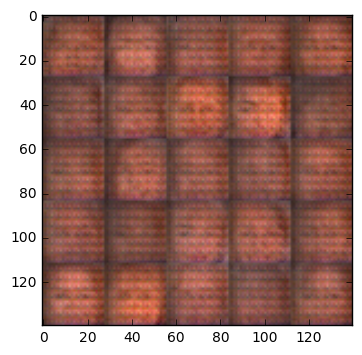

Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 1.9734
Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 1.6712
Epoch 1/1... Discriminator Loss: 0.4592... Generator Loss: 1.8951
Epoch 1/1... Discriminator Loss: 0.4475... Generator Loss: 1.9713
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 2.0694
Epoch 1/1... Discriminator Loss: 0.6324... Generator Loss: 2.7180
Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 1.3928
Epoch 1/1... Discriminator Loss: 0.4359... Generator Loss: 1.9142
Epoch 1/1... Discriminator Loss: 0.4919... Generator Loss: 1.6481
Epoch 1/1... Discriminator Loss: 0.7308... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 0.5379... Generator Loss: 1.5268
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 1.6447
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 2.1218
Epoch 1/1... Discriminator Loss: 0.4887... Generator Loss: 2.1631
Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 1.8189


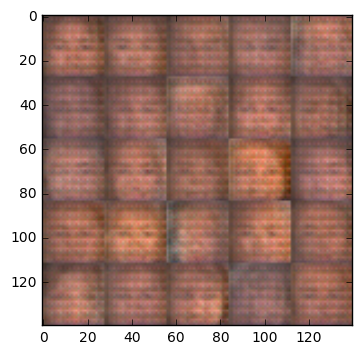

IndexError: list index out of range

In [67]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.